## Imports

In [1]:
import copy
import pickle
import sys
import tempfile
import uuid
from pathlib import Path

import tqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

In [2]:
submission_path = Path("../XTXStarterKit/").as_posix()
if submission_path not in sys.path:
    sys.path.insert(0, submission_path)

In [3]:
import python.utils
import python.model

In [4]:
pd.set_option("max_columns", 10000)
pd.set_option("max_rows", 10000)

In [5]:
%load_ext autoreload
%autoreload 2

## Parameters

In [6]:
try:
    NOTEBOOK_PATH
    UNIQUE_PATH
except NameError:
    NOTEBOOK_PATH = Path("train_temporal_convnet").resolve()
    NOTEBOOK_PATH.mkdir(exist_ok=True)
    unique_id = uuid.uuid4().hex[:8]
    UNIQUE_PATH = NOTEBOOK_PATH.joinpath(unique_id)
    UNIQUE_PATH.mkdir()
NOTEBOOK_PATH, UNIQUE_PATH

(PosixPath('/home/kimlab1/strokach/workspace/2019-xtx-forecasting-challenge/notebooks/train_temporal_convnet'),
 PosixPath('/home/kimlab1/strokach/workspace/2019-xtx-forecasting-challenge/notebooks/train_temporal_convnet/ad92fe1f'))

In [7]:
device = torch.device("cuda:2")

## Workspace

In [8]:
!ls ../data/

data-training.csv.gz


### Load data

In [9]:
try:
    with Path(tempfile.gettempdir()).joinpath(NOTEBOOK_PATH.name, "train_data_2.pkl").open("rb") as fin:
        TRAIN_TEST_SPLITS = pickle.load(fin)
except FileNotFoundError:
    %run prepare_training_data_2.ipynb
    temp_data_path = Path(tempfile.gettempdir()).joinpath(NOTEBOOK_PATH.name)
    temp_data_path.mkdir(exist_ok=True)
    with temp_data_path.joinpath("train_data_2.pkl").open("wb") as fout:
        pickle.dump(TRAIN_TEST_SPLITS, fout, pickle.HIGHEST_PROTOCOL)

In [10]:
train_df, valid_df = TRAIN_TEST_SPLITS[-1]

In [11]:
train_df.head()

askSize0      askSize1      askSize2      askSize3      askSize4  \
1 -1.554728e-08 -5.182426e-09  7.246383e-08  5.580352e-02 -3.661397e-08   
2 -1.554728e-08 -5.182426e-09  7.246383e-08 -5.580362e-08  1.757466e-02   
3 -1.554728e-08 -5.182426e-09  7.246383e-08 -5.580362e-08  1.757469e-01   
4 -1.554728e-08 -5.182426e-09  7.246383e-08 -5.580362e-08  8.787343e-02   
5 -1.554728e-08 -5.182426e-09  7.246383e-08 -5.580362e-08  1.054482e+00   

       askSize5      askSize6      askSize7      askSize8      askSize9  \
1 -2.723314e-08 -4.396649e-08 -2.832329e-08 -2.519528e-08 -4.392574e-08   
2 -2.723314e-08 -4.396649e-08 -2.832329e-08 -2.519528e-08 -4.392574e-08   
3 -2.723314e-08 -4.396649e-08 -2.832329e-08 -2.519528e-08 -4.392574e-08   
4 -2.723314e-08 -4.396649e-08 -2.832329e-08 -2.519528e-08 -4.392574e-08   
5 -2.723314e-08 -4.396649e-08 -2.832329e-08 -2.519528e-08 -4.392574e-08   

      askSize10     askSize11     askSize12     askSize13     askSize14  \
1 -2.510042e-08 -9.300603e-09 -4.340281e-08 -3.102509e-09 -1.552411e-08   
2 -2.510042e-08 -9.300603e-09 -4.340281e-08 -3.102509e-09 -1.552411e-08   
3 -2.510042e-08 -9.300603e-09 -4.340281e-08 -3.102509e-09 -1.552411e-08   
4 -2.510042e-08 -9.300603e-09 -4.340281e-08 -3.102509e-09 -1.552411e-08   
5 -2.510042e-08 -9.300603e-09 -4.340281e-08 -3.102509e-09 -1.552411e-08   

   askRate0  askRate1  askRate2  askRate3  askRate4  askRate5  askRate6  \
1       0.0       0.0       0.0       0.5       0.5       0.5       0.5   
2       0.0       0.0       0.0       0.0       0.5       0.5       0.5   
3       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
4       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
5       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

   askRate7  askRate8  askRate9  askRate10  askRate11  askRate12  askRate13  \
1       0.5       0.5       0.5        0.5        0.5        0.5        0.5   
2       0.5       0.5       0.5        0.5        0.5        0.5        0.5   
3       0.0       0.0       0.0        0.0        0.0        0.0        0.0   
4       0.0       0.0       0.0        0.0        0.0        0.0        0.0   
5       0.0       0.0       0.0        0.0        0.0        0.0        0.0   

   askRate14  bidSize0  bidSize1  bidSize2  bidSize3  bidSize4  bidSize5  \
1        0.5  0.088079  0.033459 -0.240173  0.124529  0.283590  0.097998   
2        0.5  0.088079  0.033459 -0.240173  0.124529  0.262336  0.097998   
3        0.0  0.088079  0.033459 -0.240173  0.124529  0.049796  0.097998   
4        0.0  0.088079  0.033459 -0.240173  0.124529 -0.056474  0.097998   
5        0.0  0.088079  0.033459 -0.240173  0.124529 -1.331713  0.097998   

   bidSize6  bidSize7  bidSize8  bidSize9  bidSize10  bidSize11  bidSize12  \
1  0.279013  0.345388  0.215689  0.220643   0.431199   0.152684   0.105843   
2  0.279013  0.345388  0.215689  0.220643   0.431199   0.152684   0.105843   
3  0.279013  0.345388  0.215689  0.220643   0.431199   0.152684   0.105843   
4  0.279013  0.345388  0.215689  0.220643   0.431199   0.152684   0.105843   
5  0.279013  0.345388  0.215689  0.220643   0.431199   0.152684   0.105843   

   bidSize13  bidSize14  bidRate0  bidRate1  bidRate2  bidRate3  bidRate4  \
1   0.166782   0.210288 -4.463837 -3.422022 -3.903565 -3.293856 -3.112814   
2   0.166782   0.210288 -4.463837 -3.422022 -3.903565 -3.293856 -3.383084   
3   0.166782   0.210288 -4.463837 -3.422022 -3.903565 -3.293856 -3.383084   
4   0.166782   0.210288 -4.463837 -3.422022 -3.903565 -3.293856 -3.383084   
5   0.166782   0.210288 -4.463837 -3.422022 -3.903565 -3.293856 -3.383084   

   bidRate5  bidRate6  bidRate7  bidRate8  bidRate9  bidRate10  bidRate11  \
1 -2.557257 -3.228269 -3.033949 -2.912396 -2.743385  -2.455816  -2.344185   
2 -2.779479 -3.436602 -3.230028 -3.101076 -2.921956  -2.617106  -2.500435   
3 -2.779479 -3.436602 -3.230028 -3.101076 -2.921956  -2.617106  -2.500435   
4 -2.779479 -3.436602 -3.230028

### Define model

In [12]:
%%file {UNIQUE_PATH}/model.py
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset


class XTXDataset(Dataset):
    max_values = None

    def __init__(self, data, num_previous=1, mode="train") -> None:
        super().__init__()
        assert num_previous > 0
        self.values = data[:, -2:-1].copy()
        self.targets = data[:, -1:].copy()
        self.num_previous = num_previous
        self.mode = mode

    def __len__(self):
        if self.mode == "train":
            return self.targets.shape[0] // self.num_previous - 1
        else:
            return self.targets.shape[0] - self.num_previous + 1

    def __getitem__(self, index):
        if self.mode == "train":
            offset = np.random.randint(0, self.num_previous - 1)
            step = self.num_previous
        else:
            offset = 0
            step = 1

        start = offset + index * step
        stop = start + self.num_previous

        values = self.values[start:stop, :]
        targets = self.targets[start:stop, :]

        return values, targets


class XTXModel(nn.Module):
    def __init__(self, input_size, output_size, kernel_sizes, num_previous, dropout):
        super().__init__()
        self.num_previous = num_previous

        self.layer1 = nn.Sequential(
            #
            nn.Conv1d(input_size, 10, kernel_size=kernel_sizes[0], stride=1, padding=0),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Conv1d(10, output_size, kernel_size=kernel_sizes[1], stride=1, padding=0),
        )

    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.layer1(x)
        x = x.transpose(1, 2)
        return x

    
class XTXModel2(nn.Module):
    def __init__(self, input_size, output_size, kernel_sizes, num_previous, dropout):
        super().__init__()
        self.num_previous = num_previous

        self.layer1 = nn.Sequential(
            #
            nn.Conv1d(input_size, 2, kernel_size=5, stride=3, padding=0),
            nn.ReLU(),
            nn.BatchNorm1d(2),
            nn.Dropout(dropout),
            nn.Conv1d(2, 10, kernel_size=50, stride=1, padding=0),
            nn.ReLU(),
            nn.BatchNorm1d(10),
            nn.Dropout(dropout),
            nn.Conv1d(10, output_size, kernel_size=3, stride=1, padding=0),
        )

    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.layer1(x)
        x = x.transpose(1, 2)
        return x


def _get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

Writing /home/kimlab1/strokach/workspace/2019-xtx-forecasting-challenge/notebooks/train_temporal_convnet/ad92fe1f/model.py


In [13]:
%run {UNIQUE_PATH}/model.py

### Train model

In [14]:
batch_size = 600
num_previous = 1000
kernel_sizes = [100, 3]
dropout = 0.5

In [15]:
train_dataset = XTXDataset(train_df.astype(np.float32).values, num_previous, mode="train")
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
print(len(train_dataset))

valid_dataset = XTXDataset(valid_df.astype(np.float32).values, num_previous, mode="train")
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
print(len(valid_dataset))

2398
599


In [16]:
net = XTXModel(1, 1, kernel_sizes=kernel_sizes, num_previous=num_previous, dropout=dropout).to(device)
criterion = nn.MSELoss()
optimizer = optim.AdamW(net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[3, 6], gamma=0.1)

In [17]:
num_back = 10
end_offset = sum(kz - 1 for kz in kernel_sizes) - num_back
start_offset = sum(kz - 1 for kz in kernel_sizes) - end_offset

zero_pad_start = torch.zeros(batch_size, max(0, start_offset), 1).to(device)
zero_pad_x = torch.zeros(batch_size, end_offset, 1).to(device)
zero_pad_end = torch.zeros(batch_size, end_offset, 1).to(device)

for epoch in range(200):
    net.train()
    train_losses = []
    for i, batch in enumerate(train_loader):
        x, y = batch
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        x_in = torch.cat(
            [
                zero_pad_start[: x.size(0), :, :],
                zero_pad_x[: x.size(0), :, :],
                x[:, zero_pad_x.size(1) :, :],
                zero_pad_end[: x.size(0), :, :],
            ],
            1,
        )
        x_out = net(x_in)
        loss = criterion(x_out, y)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    print(f"{sum(train_losses) / len(train_losses):.4f}", end=" ")
    train_loss = sum(train_losses) / len(train_losses)

    if (epoch + 1) % 10 == 0:
        net.eval()
        valid_losses = []
        valid_mid_losses = []
        valid_start_losses = []
        valid_end_losses = []
        for i, batch in enumerate(valid_loader):
            x, y = batch
            x = x.to(device)
            y = y.to(device)

            x_in = torch.cat(
                [
                    zero_pad_start[: x.size(0), :, :],
                    zero_pad_x[: x.size(0), :, :],
                    x[:, zero_pad_x.size(1) :, :],
                    zero_pad_end[: x.size(0), :, :],
                ],
                1,
            )
            with torch.no_grad():
                x_out = net(x_in)
            loss = criterion(x_out, y)
            loss_mid = criterion(
                x_out[:, end_offset:-end_offset], y[:, end_offset:-end_offset]
            )
            loss_start = criterion(x_out[:, :end_offset], y[:, :end_offset])
            loss_stop = criterion(x_out[:, -end_offset:], y[:, -end_offset:])
            valid_losses.append(loss.item())
            valid_mid_losses.append(loss_mid.item())
            valid_start_losses.append(loss_start.item())
            valid_end_losses.append(loss_stop.item())
        print(
            "    "
            f"{sum(valid_losses) / len(valid_losses):.4f} {sum(valid_mid_losses) / len(valid_mid_losses):.4f} "
            f"{sum(valid_start_losses) / len(valid_start_losses):.4f} {sum(valid_end_losses) / len(valid_end_losses):.4f}"
        )

0.5546 0.5459 0.5386 0.5372 0.5240 0.5177 0.5086 0.4944 0.4876 0.4760     0.3165 0.3135 0.3363 0.3240
0.4634 0.4484 0.4303 0.4159 0.3934 0.3731 0.3597 0.3350 0.3198 0.3002     0.1832 0.1669 0.2662 0.2470
0.2771 0.2590 0.2451 0.2320 0.2142 0.2005 0.1882 0.1749 0.1648 0.1561     0.0744 0.0474 0.2092 0.1822
0.1495 0.1435 0.1366 0.1310 0.1289 0.1255 0.1239 0.1204 0.1203 0.1188     0.0450 0.0147 0.1958 0.1660
0.1173 0.1169 0.1181 0.1152 0.1151 0.1139 0.1134 0.1133 0.1111 0.1134     0.0426 0.0119 0.1955 0.1652
0.1115 0.1112 0.1117 0.1104 0.1087 0.1095 0.1090 0.1086 0.1063 0.1087     0.0423 0.0115 0.1957 0.1653
0.1081 0.1077 0.1075 0.1085 0.1047 0.1019 0.1043 0.1031 0.1058 0.1074     0.0416 0.0107 0.1957 0.1653
0.1025 0.1028 0.1023 0.1036 0.1055 0.1028 0.0999 0.1014 0.0999 0.1008     0.0407 0.0097 0.1953 0.1651
0.1008 0.0989 0.1005 0.0989 0.0971 0.0962 0.0985 0.0977 0.0997 0.0966     0.0397 0.0085 0.1947 0.1646
0.0973 0.0991 0.0962 0.0955 0.0968 0.0969 0.0932 0.0949 0.0938 0.0960     0.0386 0

In [18]:
net.eval()
for param in net.parameters():
    param.requires_grad = False

In [19]:
zero_pad_start.shape

torch.Size([600, 10, 1])

In [20]:
train_dataset = XTXDataset(valid_df.astype(np.float32).values, num_previous=600000, mode="valid")

In [21]:
valid_dataset = XTXDataset(valid_df.astype(np.float32).values, num_previous=600000, mode="valid")

In [22]:
len(valid_dataset)

1

In [23]:
x, y = valid_dataset[0]
x = torch.from_numpy(x).to(device).unsqueeze(0)
y = torch.from_numpy(y).to(device).unsqueeze(0)

In [24]:
x_in = torch.cat(
    [zero_pad_start[: x.size(0), :, :], x, zero_pad_end[: x.size(0), :, :]], 1
)
x_out = net(x_in)

In [25]:
cpu = torch.device("cpu")

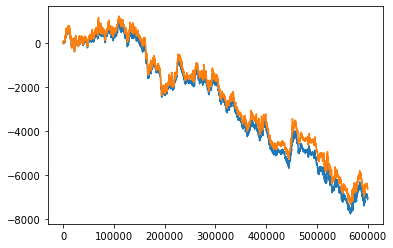

In [26]:
pred = np.cumsum(x_out.squeeze().to(cpu).data.numpy())
actual = np.cumsum(y.squeeze().to(cpu).data.numpy())
plt.plot(pred)
plt.plot(actual)

In [27]:
stats = []
for i in range(0, len(pred)):
    

SyntaxError: unexpected EOF while parsing (<ipython-input-27-f3d3ef83d2b2>, line 3)

In [ ]:
len(pred)

In [ ]:
len(actual)

In [ ]:
from scipy import stats

In [ ]:
stats.pearsonr(pred, actual[1:len(pred) + 1])

In [ ]:
(0.9999665754240266, 0.0)


In [ ]:
b.shape

In [ ]:
batch_size = 20000
kernel_sizes = [30, 3]
num_previous = 300

train_dataset = XTXDataset(train_df.astype(np.float32).values, num_previous, mode="valid")
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
print(len(train_dataset))

valid_dataset = XTXDataset(valid_df.astype(np.float32).values, num_previous, mode="valid")
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
print(len(valid_dataset))

In [ ]:
net2 = XTXModel(2, 1, kernel_sizes=kernel_sizes, num_previous=num_previous, dropout=dropout).to(device)
criterion = nn.MSELoss()
optimizer = optim.AdamW(net2.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[3, 6], gamma=0.1)

In [ ]:
history_offset = 90
zero_pad_history = torch.zeros(batch_size, history_offset, 1).to(device)

zero_pad_x2 = torch.zeros(batch_size, sum(kz - 1 for kz in kernel_sizes), 2).to(device)

num_back = 10
end_offset = sum(kz - 1 for kz in kernel_sizes) - num_back
start_offset = sum(kz - 1 for kz in kernel_sizes) - end_offset

zero_pad_start = torch.zeros(batch_size, max(0, start_offset), 1).to(device)
zero_pad_x = torch.zeros(batch_size, end_offset, 1).to(device)
zero_pad_end = torch.zeros(batch_size, end_offset, 1).to(device)

for epoch in range(200):
    net2.train()
    train_losses = []
    train_scores = []
    for i, batch in enumerate(train_loader):
        x, y = batch
        x = x.to(device)
        y = y.to(device)

        # Net 1
        x_in = torch.cat([x, zero_pad_end[: x.size(0), :, :]], 1)
        x_out = net(x_in)
        x_out = x_out[:, :-history_offset, :]

        # Net 2
        optimizer.zero_grad()
        x_in = torch.cat([x_out, x[:, -x_out.size(1) :, :]], dim=2)
        x_out = net2(x_in)
        #         loss = criterion(x_out, y)
        loss = ((y[:, -1, :] - x_out[:, -1, :]) ** 2).sum() / (y[:, -1, :] ** 2).sum()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        score = 1 - ((y[:, -1, :] - x_out[:, -1, :]) ** 2).sum() / (y[:, -1, :] ** 2).sum()
        train_scores.append(score.item())

    print(f"{sum(train_losses) / len(train_losses):.4f}", end=" ")
    train_loss = sum(train_losses) / len(train_losses)

    if (epoch + 1) % 1 == 0:
        net2.eval()
        valid_losses = []
        valid_scores = []
        valid_mid_losses = []
        valid_start_losses = []
        valid_end_losses = []
        for i, batch in enumerate(valid_loader):
            x, y = batch
            x = x.to(device)
            y = y.to(device)

            # Net 1
            x_in = torch.cat([x, zero_pad_end[: x.size(0), :, :]], 1)
            x_out = net(x_in)
            x_out = x_out[:, :-history_offset, :]

            # Net 2
            x_in = torch.cat([x_out, x[:, -x_out.size(1) :, :]], dim=2)
            with torch.no_grad():
                x_out = net2(x_in)
            loss = criterion(x_out[:, -1, :], y[:, -1, :])
            valid_losses.append(loss.item())

            score = (
                1
                - ((y[:, -1, :] - x_out[:, -1, :]) ** 2).sum()
                / (y[:, -1, :] ** 2).sum()
            )
            valid_scores.append(score.item())

        print(
            "    "
            f"{sum(valid_losses) / len(valid_losses):.4f} {sum(valid_scores) / len(valid_scores):.4f}"
            #             f"{sum(valid_losses) / len(valid_losses):.4f} {sum(valid_mid_losses) / len(valid_mid_losses):.4f} "
            #             f"{sum(valid_start_losses) / len(valid_start_losses):.4f} {sum(valid_end_losses) / len(valid_end_losses):.4f}"
        )

In [ ]:
x.shape

In [ ]:
zero_pad_end.shape

In [ ]:
90
0.5127 0.5103 0.5083 0.5066 0.5077 0.5062 0.5027 0.5022 0.4994 0.4957     0.5589 0.5580 0.5448 0.5812
0.4922 0.4865 0.4820 0.4733 0.4643 0.4511 0.4366 0.4231 0.4061 0.3851     0.4124 0.4043 0.3946 0.5032
0.3652 0.3440 0.3255 0.3023 0.2801 0.2610 0.2444 0.2302 0.2185 0.2121     0.1511 0.1275 0.1237 0.3899
0.2077 0.2073 0.2050 0.2028 0.2030 0.2010 0.1997 0.1971 0.1960 0.1952     0.1291 0.1039 0.1002 0.3840
0.1942 0.1925 0.1923 0.1900 0.1900 0.1890 0.1879 0.1877 0.1858 0.1840     0.1233 0.0977 0.0942 0.3819
0.1847 0.1834 0.1817 0.1810 0.1803 0.1792 0.1785 0.1757 0.1765 0.1759     0.1148 0.0886 0.0855 0.3797
0.1742 0.1724 0.1701 0.1710 0.1699 0.1680 0.1677 0.1672 0.1646 0.1652     0.1007 0.0733 0.0708 0.3761
0.1644 0.1648 0.1630 0.1617 0.1622 0.1629 0.1610 0.1613 0.1603 0.1603     0.0888 0.0604 0.0585 0.3739
0.1609 0.1591 0.1598 0.1593 0.1602 0.1589 0.1589 0.1595 0.1591 0.1587     0.0820 0.0530 0.0514 0.3725
0.1588 0.1583 0.1583 0.1589 0.1574 0.1580 0.1574 0.1584 0.1569 0.1582     0.0799 0.0508 0.0492 0.3720
0.1576 0.1572 0.1574 0.1575 0.1581 0.1574 0.1576 0.1583 0.1568 0.1582     0.0797 0.0505 0.0490 0.3719
0.1580 0.1568 0.1577 0.1577 0.1566 0.1570 0.1585 0.1565 0.1557 0.1574     0.0794 0.0503 0.0488 0.3718
0.1570 0.1563 0.1576 0.1568 0.1562 0.1573 0.1566 0.1578 0.1575 0.1563     0.0793 0.0501 0.0486 0.3717
0.1564 0.1573 0.1567 0.1569 0.1562 0.1562 0.1575 0.1558 0.1565 0.1571     0.0791 0.0500 0.0485 0.3716
0.1564 0.1556 0.1572 0.1568 0.1564 0.1561 0.1577 0.1567 0.1557 0.1572     0.0790 0.0498 0.0483 0.3715
0.1563 0.1570 0.1575 0.1564 0.1571 0.1566 0.1558 0.1558 0.1563 0.1556     0.0789 0.0497 0.0483 0.3715
0.1565 0.1564 0.1559 0.1555 0.1558 0.1568 0.1576 0.1572 0.1569 0.1558     0.0789 0.0498 0.0483 0.3715
0.1557 0.1559 0.1558 0.1560 0.1572 0.1562 0.1565 0.1563 0.1558 0.1580     0.0787 0.0496 0.0481 0.3714
0.1567 0.1563 0.1556 0.1563 0.1553 0.1560 0.1561 0.1562 0.1562 0.1561     0.0789 0.0497 0.0482 0.3714
0.1572 0.1566 0.1568 0.1558 0.1570 0.1560 0.1562 0.1570 0.1558 0.1556     0.0790 0.0499 0.0484 0.3714

In [ ]:
0.5261 0.5263 0.5224 0.5191 0.5187 0.5169 0.5113 0.5098 0.5056 0.5071     0.5790 0.5808
0.5029 0.4981 0.4970 0.4882 0.4822 0.4769 0.4678 0.4570 0.4472 0.4335     0.4907 0.4879
0.4173 0.4030 0.3880 0.3657 0.3492 0.3267 0.3054 0.2852 0.2649 0.2453     0.2570 0.2407
0.2296 0.2146 0.2046 0.1961 0.1899 0.1863 0.1821 0.1783 0.1756 0.1738     0.1366 0.1122
0.1703 0.1682 0.1664 0.1648 0.1624 0.1614 0.1584 0.1569 0.1551 0.1542     0.1348 0.1103
0.1520 0.1525 0.1496 0.1476 0.1478 0.1460 0.1445 0.1426 0.1410 0.1402     0.1240 0.0987
0.1380 0.1371 0.1366 0.1347 0.1332 0.1321 0.1315 0.1295 0.1293 0.1276     0.1079 0.0815
0.1264 0.1259 0.1248 0.1238 0.1236 0.1231 0.1223 0.1215 0.1210 0.1209     0.0935 0.0660
0.1206 0.1197 0.1192 0.1193 0.1184 0.1184 0.1184 0.1186 0.1182 0.1174     0.0852 0.0570
0.1176 0.1174 0.1173 0.1174 0.1173 0.1164 0.1170 0.1171 0.1169 0.1163     0.0821 0.0538

In [ ]:
cpu = torch.device("cpu")

In [ ]:
plt.plot(np.cumsum(x[0, :, 0].squeeze().to(cpu).data.numpy()))

In [ ]:
plt.plot(x[0, :, 0].squeeze().to(cpu).data.numpy())

In [ ]:
y_cumsum = np.cumsum(y[0, :, 0].squeeze().to(cpu).data.numpy())
pred_cumsum = np.cumsum(x_out[0, :, 0].squeeze().to(cpu).data.numpy())

# pred_cumsum = pred_cumsum / (pred_cumsum.max() - pred_cumsum.min()) * (y_cumsum.max() - y_cumsum.min()) 

plt.plot(pred_cumsum)
plt.plot(y_cumsum)

In [ ]:
x.shape

In [ ]:
    net.eval()
    random_gen.manual_seed(42)
    val_losses = []
    val_losses2 = []
    for i, batch in enumerate(valid_loader):
        x, y = batch
        x = x.to(device)
        y = y.to(device)

        with torch.no_grad():
            x_out = net(x_in)
        loss = criterion(x_out, y[: x_out.size(0), :])
        val_losses.append(loss.item())
    val_loss = sum(val_losses) / len(val_losses)
    balanced_loss = 0.4 * val_loss + 0.4 * val_loss2 + 0.2 * train_loss

    print(
        f"Train: {train_loss:.6f}, Valid: {val_loss:.6f}, Valid 2: {val_loss2:.6f}, Balanced: {balanced_loss:.6f}"
    )
    if balanced_loss > max_balanced_loss:
        break
    else:
        max_balanced_loss = balanced_loss

In [ ]:
batch_size = 256
num_previous = 1000
kernel_size = 100
dropout = 0.5

while True:
    unique_id = str(uuid.uuid4())
    unique_path = NOTEBOOK_PATH.joinpath(unique_id)
    try:
        unique_path.mkdir()
        break
    except FileExistsError:
        continue
print(f"Unique id: '{unique_id}'\n")

max_weighted_scores = []
for split_index, (train_df, valid_df) in enumerate(TRAIN_TEST_SPLITS):
    print(f"Split: {split_index}")

    train_dataset = XTXDataset(train_df.astype(np.float32).values, num_previous)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

    valid_dataset = XTXDataset(valid_df.astype(np.float32).values, num_previous)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    max_weighted_score = 0
    for repeat_index in range(3):
        print(f"Repeat: {repeat_index}")
        net = XTXModel(dropout=dropout, num_previous=num_previous).to(device)
        criterion = nn.MSELoss(reduction="sum")
        optimizer = optim.AdamW(net.parameters(), lr=0.001)
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[3, 6], gamma=0.1)

        noise_x = torch.zeros(batch_size, 4, 15, num_previous).to(device)
        noise_y = torch.zeros(batch_size, 1).to(device)
        for epoch in range(10):
            print(f"Epoch: {epoch}")
            train_dataset = XTXDataset(train_df.astype(np.float32).values, num_previous)
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

            net.train()

            scores = []
            for i, batch in enumerate(train_loader):
                x, y = batch
                x = x.to(device)
                y = y.to(device)

                optimizer.zero_grad()
        #         noise_x.normal_(0, 0.1)
                out = net(x + noise_x[:x.size(0), :, :, :])
        #         noise_y.normal_(0, 0.1)
                loss = criterion(out, y[:, 0] + noise_y[:y.size(0), :])
                loss.backward()
                optimizer.step()

                if i % 500 == 0:
                    last_ys = y[:, 0].squeeze()
                    last_outs = out.squeeze()
                    score = (
                        1 - ((last_ys - last_outs) ** 2).sum() / (last_ys ** 2).sum()
                    ).item()
                    print(f"{score:.6f}", end=" ")
                    scores.append((i, score))
            scheduler.step()

            net.eval()
            y_list = []
            out_list = []
            for i, batch in enumerate(valid_loader):
                x, y = batch
                x = x.to(device)
                y = y.to(device)

                with torch.no_grad():
                    out = net(x)

                last_ys = y[:, 0].squeeze().to(torch.device("cpu")).data.numpy()
                last_outs = out.squeeze().to(torch.device("cpu")).data.numpy()
                y_list.append(last_ys)
                out_list.append(last_outs)

            last_ys = np.hstack(y_list)
            last_outs = np.hstack(out_list)
            score = (
                1 - ((last_outs - last_ys) ** 2).sum() / (last_ys ** 2).sum()
            ).item()
            print(f"Validation: {score:.6f}")
            
            weighted_score = (score + max(sum([s[1] for s in scores]) / len(scores), 0.04) / 4) / 2  # Need average increase of 0.02 to justify decrease of 0.005
            if weighted_score > max_weighted_score:
                max_weighted_score = weighted_score
                torch.save(net.state_dict(), unique_path.joinpath(f"model_{split_index}.pt"))

    print(f"Best weighted score for split {split_index}: {max_weighted_score:.6f}\n")
    max_weighted_scores.append(max_weighted_score)
    
print(f"Average best validation score: {sum(max_weighted_scores) / len(max_weighted_scores):.6f}")

In [ ]:
unique_id